In [1]:
import torch
from dataset import DRSegmentationDataset
from unet import UNet
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from discriminator import Discriminator

In [2]:
BATCH_SIZE = 2
GPU = 1
LAMBDA = 1

In [3]:
device = f"cuda:{GPU}" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda:1


In [4]:
torch.manual_seed(0)

In [5]:
train_dataset = DRSegmentationDataset("/home/wilk/diabetic_retinopathy/datasets/processed_segmentation_dataset/train_set")
test_dataset = DRSegmentationDataset("/home/wilk/diabetic_retinopathy/datasets/processed_segmentation_dataset/test_set")

In [6]:
image_level_train_dataset = DRSegmentationDataset("/home/wilk/diabetic_retinopathy/datasets/grading/train_set", use_masks=False)
image_level_test_dataset = DRSegmentationDataset("/home/wilk/diabetic_retinopathy/datasets/grading/test_set", use_masks=False)

In [7]:
writer = SummaryWriter(log_dir="runs/Adam_original")

# K Fold training loop

In [8]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    # print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [9]:
def train(train_dataset, epochs, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True) 
    fold_results = {fold: 0 for fold in range(k_folds)}

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        train_loader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=BATCH_SIZE, sampler=val_subsampler)
        
        model = UNet(in_channels=3, out_channels=5)
        model.to(device)

        model.apply(reset_weights)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=[0.5, 0.5])

        loss = torch.nn.BCELoss()
        
        for epoch in range(epochs):
            training_epoch_loss = 0
            validation_epoch_loss = 0

            model.train()
            for train_batch_id, train_batch in enumerate(train_loader):
                optimizer.zero_grad()
                
                input_tensor = train_batch[0].to(device)
                target_tensor = train_batch[1].to(device)

                train_output = model(input_tensor)

                loss_value = loss(train_output, target_tensor)
                loss_value.backward()
                optimizer.step()

                training_epoch_loss += loss_value.item()

            model.eval()
            with torch.no_grad():
                for val_batch_id, val_batch in enumerate(val_loader):                
                    input_tensor = val_batch[0].to(device)
                    target_tensor = val_batch[1].to(device)

                    val_output = model(input_tensor)

                    loss_value = loss(val_output, target_tensor)
                    validation_epoch_loss += loss_value.item() 

            training_epoch_loss /= len(train_loader)
            validation_epoch_loss /= len(val_loader)

            writer.add_scalar(f'Fold{fold}/Loss/Train', training_epoch_loss, epoch)
            writer.add_scalar(f'Fold{fold}/Loss/Val', validation_epoch_loss, epoch)


            print(f"Fold: {fold}, Epoch: {epoch}, Mean training loss: {training_epoch_loss}, Mean validation loss: {validation_epoch_loss}")
        fold_results[fold] = validation_epoch_loss
    
    final_fold_values = [value for k, value in fold_results.items()]
    average_validation_result = np.mean(final_fold_values)
    print("Average validation result:", average_validation_result)

    writer.add_scalar("Average validation result:", average_validation_result)

In [10]:
# train(train_dataset, 200, k_folds=5)

# Final training with Discriminator

## Validation

In [11]:
def discriminator_validation(validation_px_dataloader, validation_image_level_dataloader, generator_model, discriminator_model):
    validation_accuracy = []

    targets = []
    predicted_values = []

    generator_model.eval()
    discriminator_model.eval()
    for px_level_batch, img_level_batch in zip(validation_px_dataloader, validation_image_level_dataloader):
        
        px_level_input_tensor = px_level_batch[0].to(device)
        img_level_input_tensor = img_level_batch[0].to(device)

        # Generator masks for px level dataset and image level dataset
        px_level_output = generator_model(px_level_input_tensor)
        img_level_output = generator_model(img_level_input_tensor)

        px_level_output = torch.concat((px_level_output, px_level_input_tensor), dim=1) # Stack with original RGB image
        img_level_output = torch.concat((img_level_output, img_level_input_tensor), dim=1) # Stack with original RGB image

        px_level_target = torch.Tensor([[1] for i in range(px_level_output.shape[0])])
        img_level_target = torch.Tensor([[0] for i in range(img_level_output.shape[0])])

        discriminator_input = torch.concat((px_level_output, img_level_output), dim=0)
        discriminator_target = torch.concat((px_level_target, img_level_target), dim=0)

        indices = torch.randperm(discriminator_input.shape[0])
        discriminator_input = discriminator_input[indices, ...].to(device)
        discriminator_target = discriminator_target[indices, ...].to(device)

        discriminator_output = discriminator_model(discriminator_input)

        discriminator_output = torch.where(discriminator_output > 0.5, 1, 0)

        batch_sum = torch.sum(discriminator_output == discriminator_target) 
        batch_accuracy = batch_sum / discriminator_output.size()[0]
        validation_accuracy.append(batch_accuracy)

        targets += discriminator_target.squeeze().cpu().detach().tolist()
        predicted_values += discriminator_output.squeeze().cpu().detach().tolist()

    targets = np.array(targets)
    predicted_values = np.array(predicted_values)

    accuracy = np.mean(targets == predicted_values)

    return accuracy

## Training

In [ ]:
def train(train_dataloader, image_level_dataloader, epochs, model, discriminator_model):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=[0.5, 0.5])
        discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-5)

        loss = torch.nn.BCELoss()
        discriminator_loss = torch.nn.BCELoss()
        
        for epoch in range(epochs):
            training_epoch_loss = 0

            discriminator_epoch_loss = 0
            for px_level_batch, img_level_batch in zip(train_dataloader, image_level_dataloader):
                # Discriminator training
                model.eval()
                discriminator_model.train()
                discriminator_optimizer.zero_grad()
                
                px_level_input_tensor = px_level_batch[0].to(device)
                px_level_target_tensor = px_level_batch[1].to(device)
                img_level_input_tensor = img_level_batch[0].to(device)

                # Generator masks for px level dataset and image level dataset
                px_level_output_masks = model(px_level_input_tensor)
                img_level_output = model(img_level_input_tensor)

                px_level_output = torch.concat((px_level_output_masks.detach(), px_level_input_tensor), dim=1) # Stack with original RGB image
                img_level_output = torch.concat((img_level_output.detach(), img_level_input_tensor), dim=1) # Stack with original RGB image

                px_level_target = torch.Tensor([[1] for i in range(px_level_output.shape[0])])
                img_level_target = torch.Tensor([[0] for i in range(img_level_output.shape[0])])

                discriminator_input = torch.concat((px_level_output, img_level_output), dim=0)
                discriminator_target = torch.concat((px_level_target, img_level_target), dim=0)

                indices = torch.randperm(discriminator_input.shape[0])
                discriminator_input=discriminator_input[indices, ...].to(device)
                discriminator_target=discriminator_target[indices, ...].to(device)

                discriminator_output = discriminator_model(discriminator_input)

                discriminator_loss_value = discriminator_loss(discriminator_output, discriminator_target)

                discriminator_loss_value.backward()
                discriminator_optimizer.step()

                discriminator_epoch_loss += discriminator_loss_value

                # Generator Training
                model.train()
                discriminator_model.eval()
                optimizer.zero_grad()

                discriminator_output = discriminator_model(px_level_output)
                generator_gan_loss = discriminator_loss(discriminator_output, img_level_target.to(device))

                loss_value = loss(px_level_output_masks, px_level_target_tensor) + LAMBDA*generator_gan_loss
                loss_value.backward()
                optimizer.step()

                training_epoch_loss += loss_value.item()

                torch.cuda.empty_cache()

            accuracy = discriminator_validation(train_dataloader, image_level_dataloader, model, discriminator_model)
            mean_discriminator_loss = discriminator_epoch_loss / len(train_dataloader)

            training_epoch_loss /= len(train_dataloader)

            writer.add_scalar('Final/Loss/Train', training_epoch_loss, epoch)
            writer.add_scalar('Final/Discriminator_loss/Train', mean_discriminator_loss, epoch)

            print(f"Epoch: {epoch}, Mean training loss: {training_epoch_loss}, Mean discriminator loss: {mean_discriminator_loss}, Discriminator accuracy: {accuracy}")

In [13]:
train_dataloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(
                      test_dataset, 
                      batch_size=1)

In [14]:
image_level_train_dataloader = torch.utils.data.DataLoader(image_level_train_dataset, batch_size=BATCH_SIZE)
image_level_test_dataloader = torch.utils.data.DataLoader(image_level_test_dataset, batch_size=BATCH_SIZE)

In [15]:
model = UNet(3, 5)
model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
discriminator_model = Discriminator()
discriminator_model.to(device)

Discriminator(
  (conv_tuple_1): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_tuple_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_tuple_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0,

In [17]:
train(train_dataloader, image_level_train_dataloader, 100, model, discriminator_model=discriminator_model)

Epoch: 0, Mean training loss: 1.1344432185093563, Mean discriminator loss: 0.5158724784851074, Discriminator accuracy: 0.5
Epoch: 1, Mean training loss: 0.11958347081586167, Mean discriminator loss: 0.45377057790756226, Discriminator accuracy: 0.5
Epoch: 2, Mean training loss: 0.08427406626719015, Mean discriminator loss: 0.424259215593338, Discriminator accuracy: 0.5
Epoch: 3, Mean training loss: 1.269826889038086, Mean discriminator loss: 0.38627171516418457, Discriminator accuracy: 0.6851851851851852
Epoch: 4, Mean training loss: 2.4421709362003536, Mean discriminator loss: 0.3621920049190521, Discriminator accuracy: 0.7037037037037037
Epoch: 5, Mean training loss: 2.6682072579860687, Mean discriminator loss: 0.33732447028160095, Discriminator accuracy: 0.7129629629629629
Epoch: 6, Mean training loss: 2.879468439905732, Mean discriminator loss: 0.31600257754325867, Discriminator accuracy: 0.6944444444444444
Epoch: 7, Mean training loss: 3.081145401906084, Mean discriminator loss: 0.

In [18]:
# torch.save(model.state_dict(), "segmentation_generator.pth")

In [19]:
loaded_model = UNet(3, 5)
loaded_model.load_state_dict(torch.load("segmentation_generator.pth", map_location=device))
loaded_model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [20]:
model.eval()
loss = torch.nn.BCELoss()
test_loss = 0

with torch.no_grad():
    for test_batch_id, test_batch in enumerate(test_dataloader):                
        input_tensor = test_batch[0].to(device)
        target_tensor = test_batch[1].to(device)

        val_output = loaded_model(input_tensor)

        loss_value = loss(val_output, target_tensor)
        test_loss += loss_value.item() 

mean_test_loss = test_loss / len(test_dataloader)
print("Mean test loss:", mean_test_loss)

Mean test loss: 0.018600133506374225


/tmp/ipykernel_711858/4133532162.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


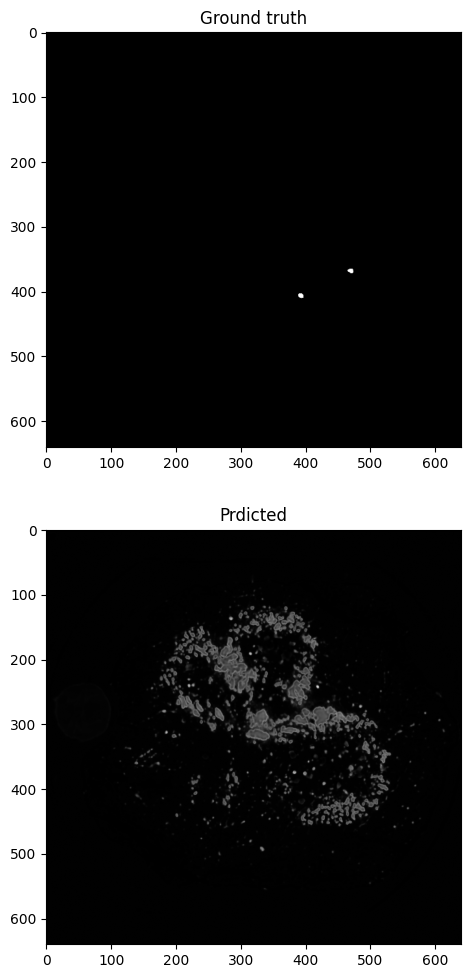

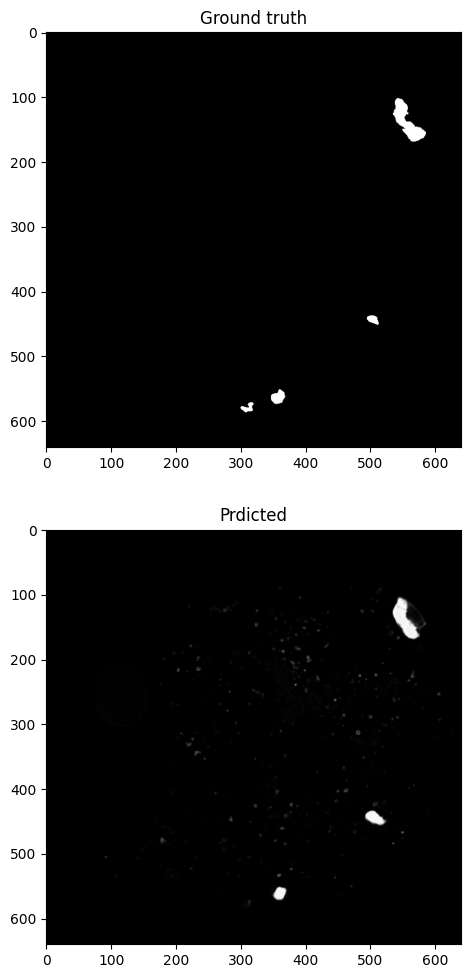

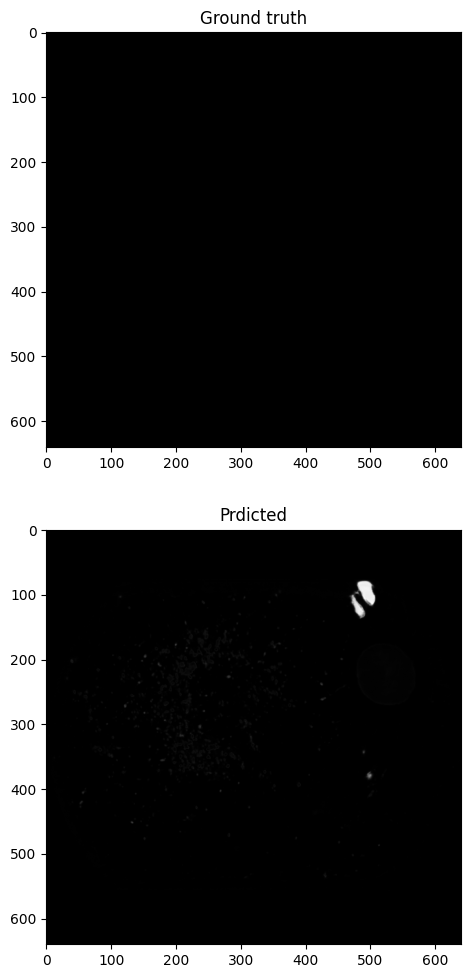

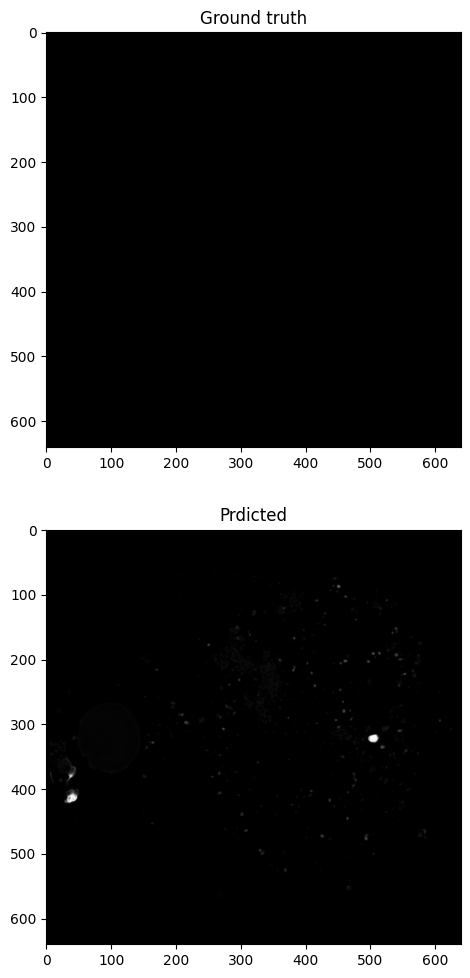

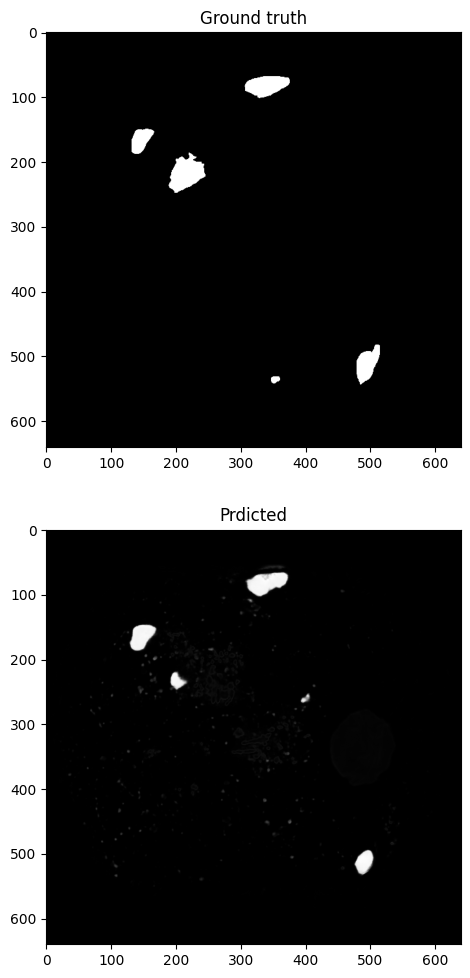

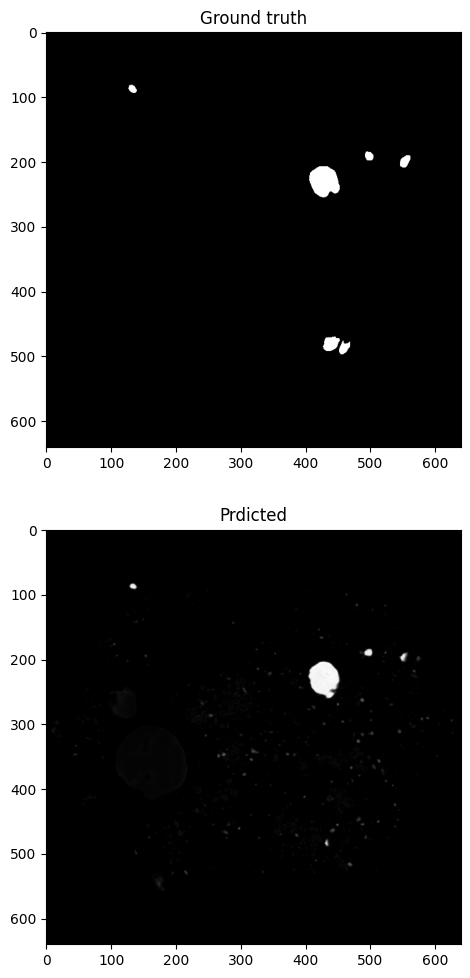

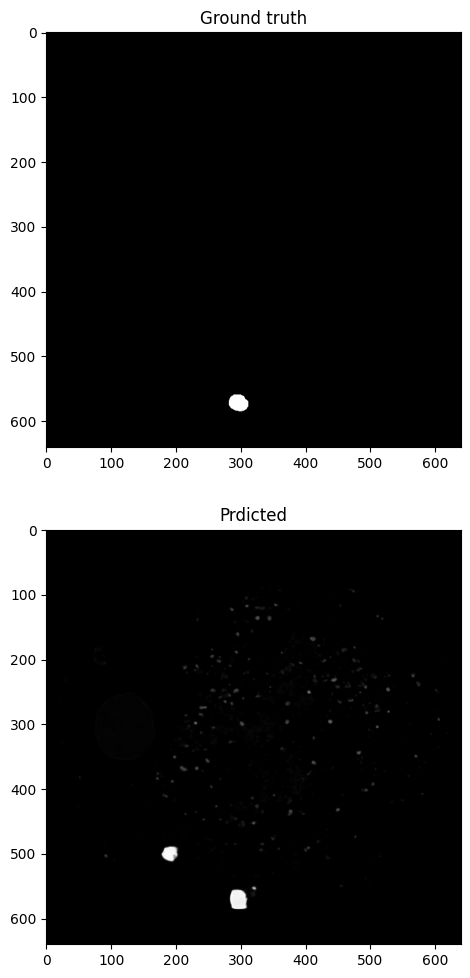

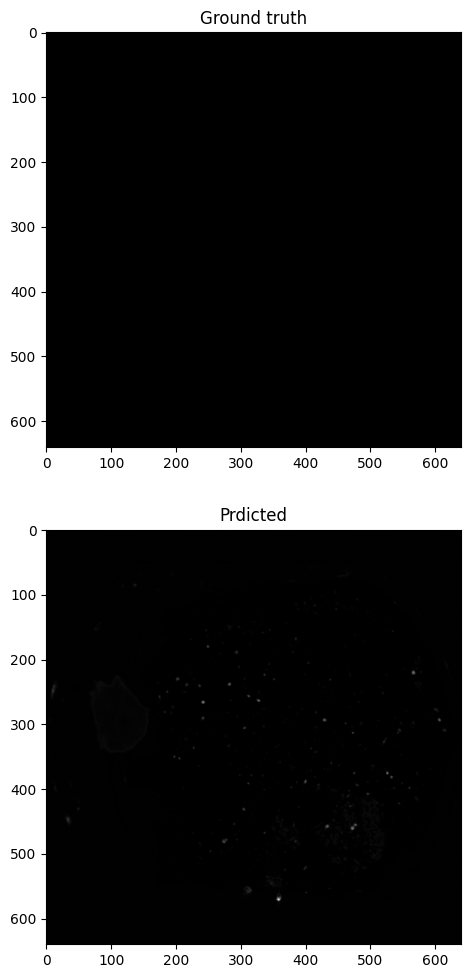

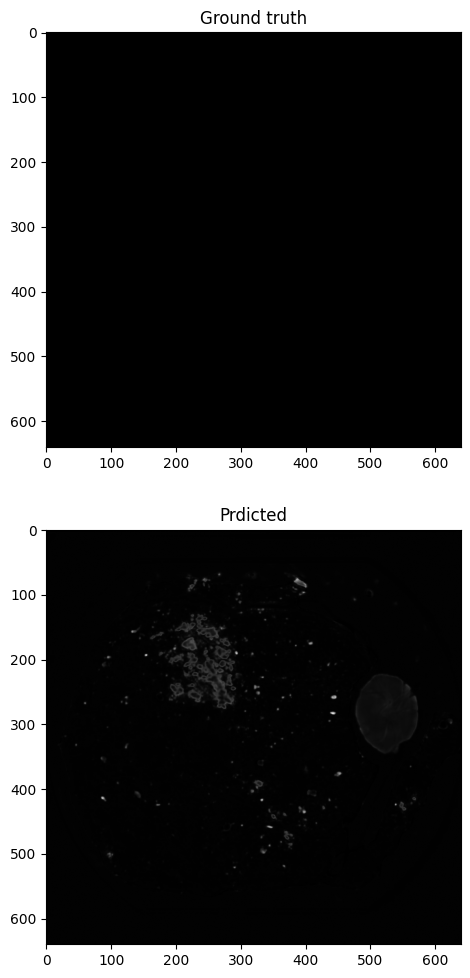

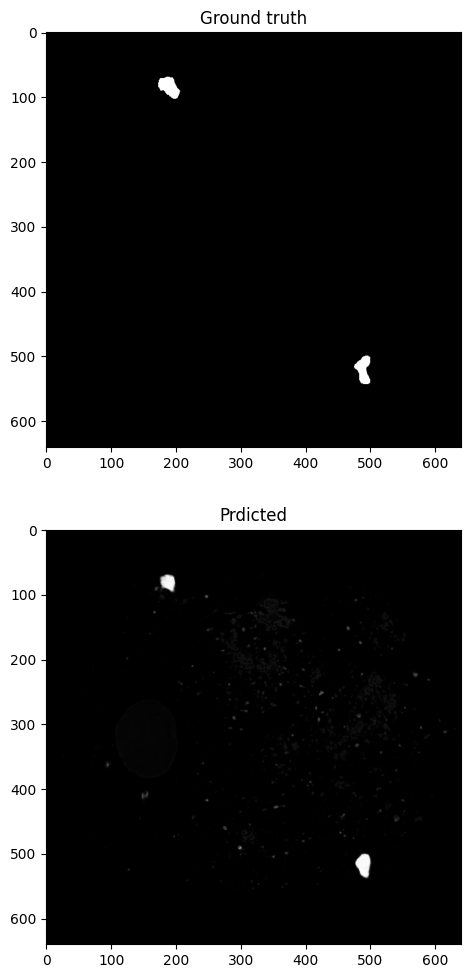

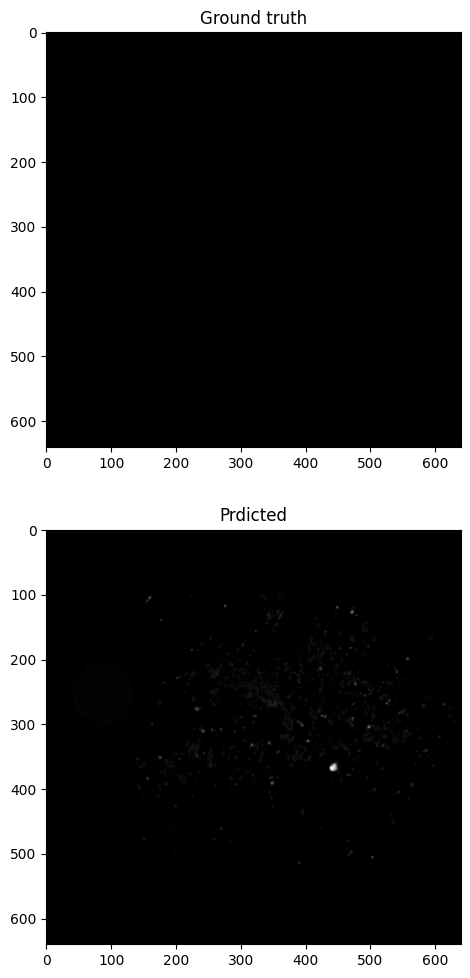

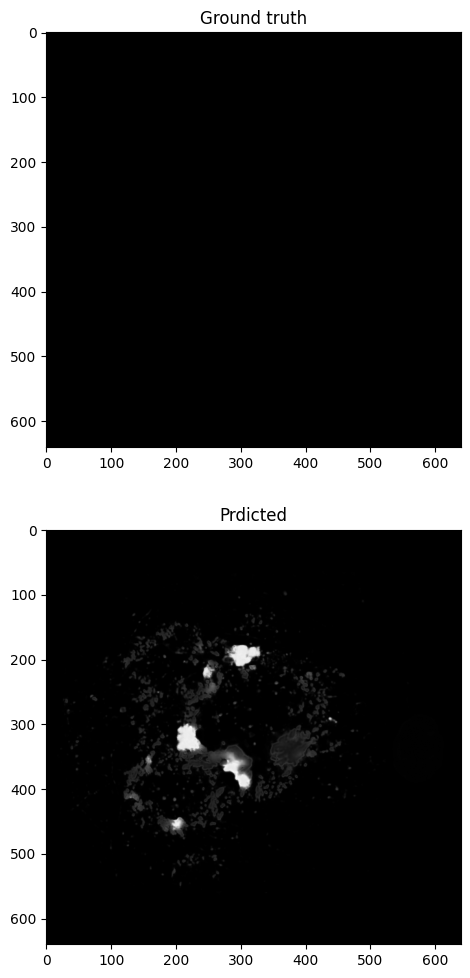

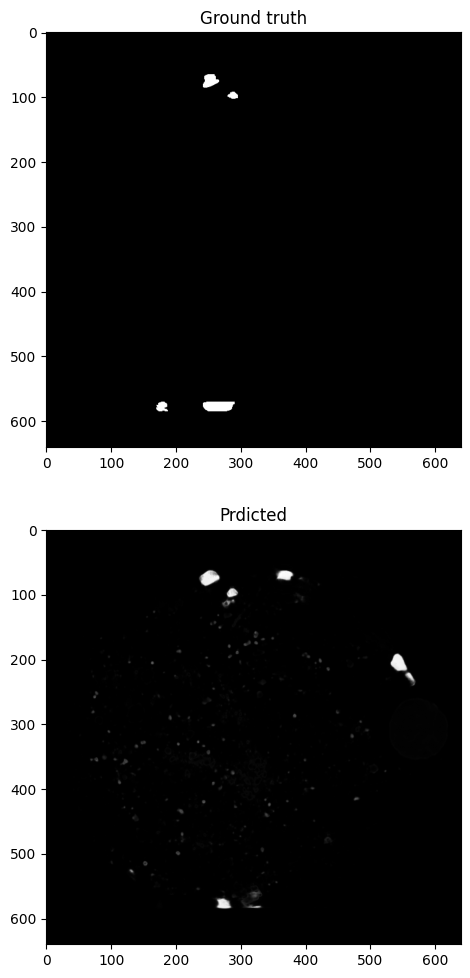

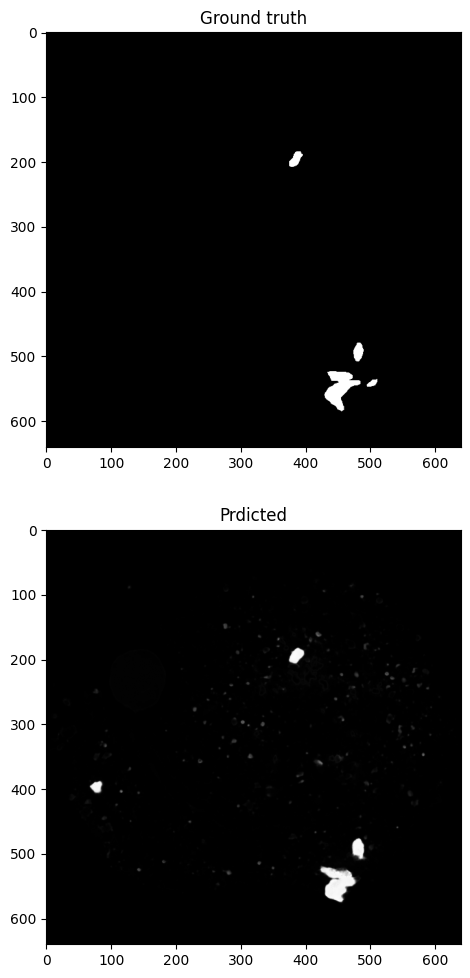

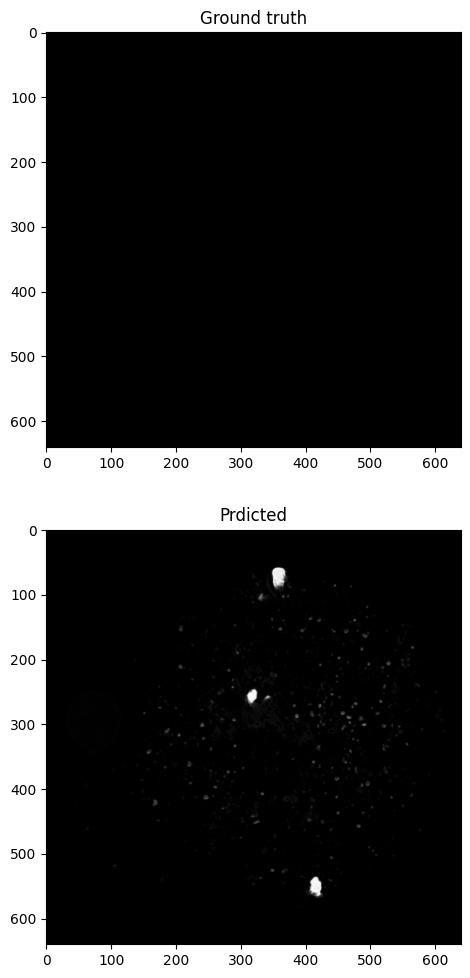

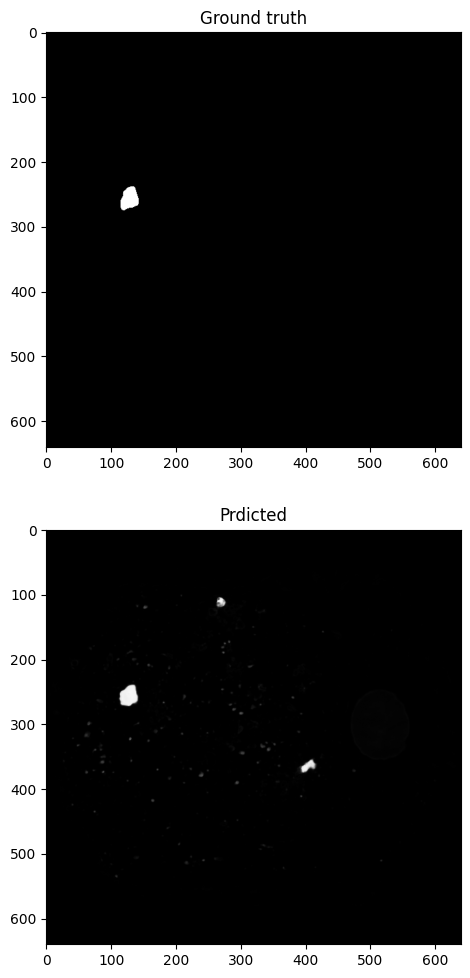

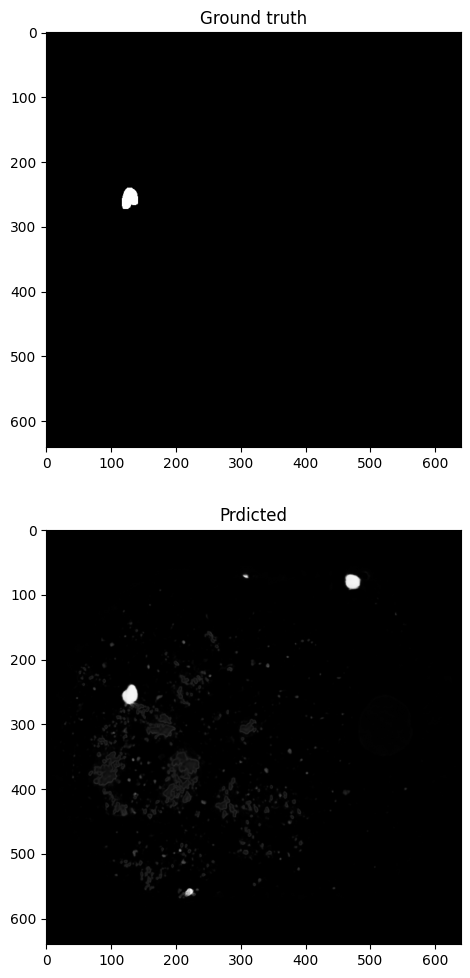

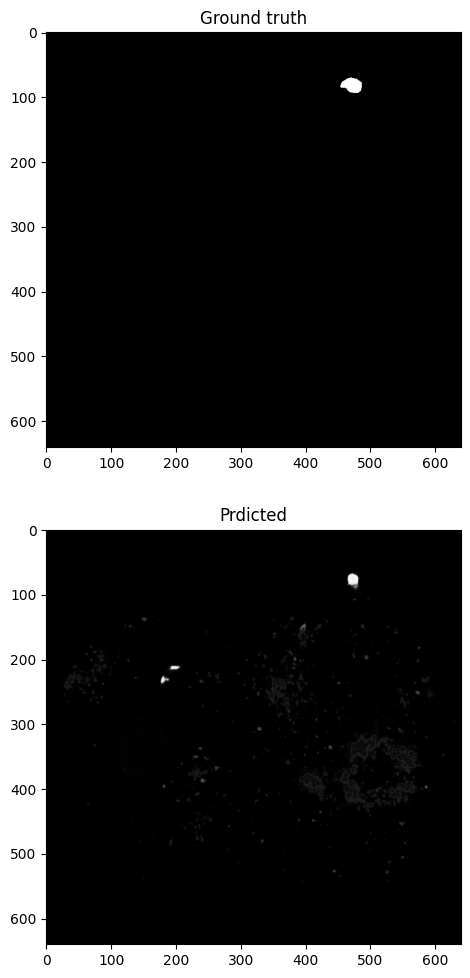

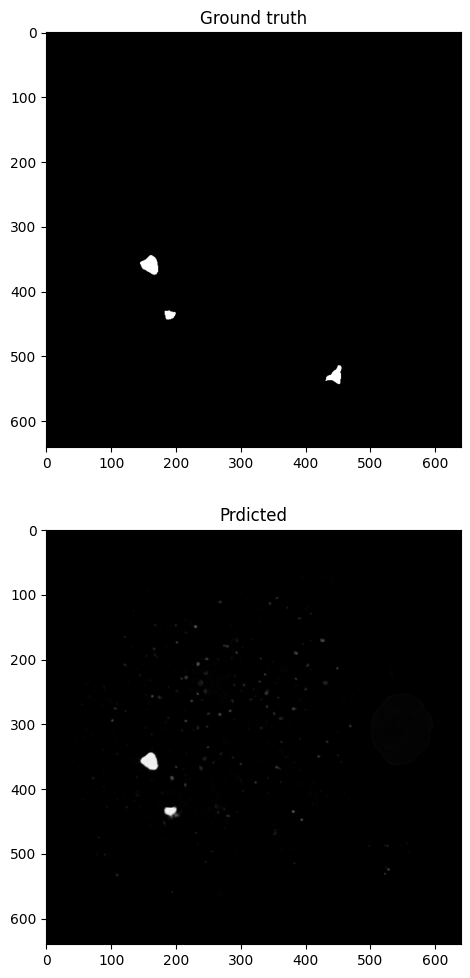

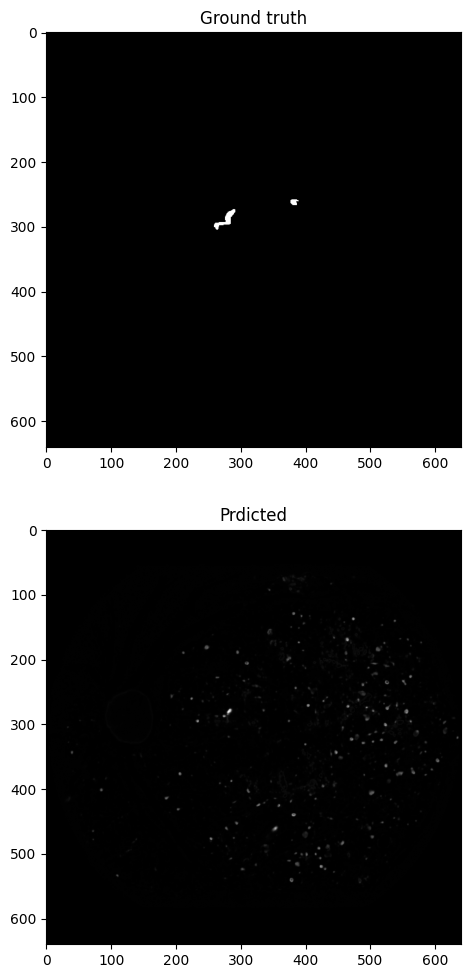

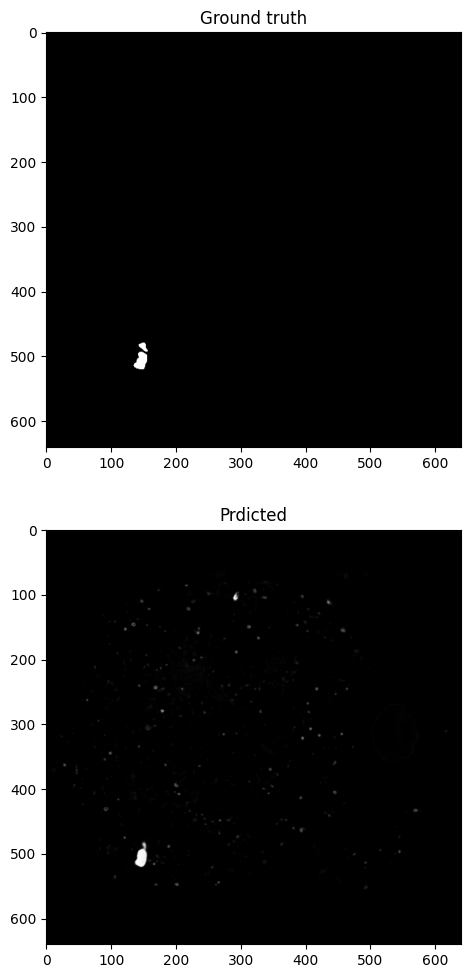

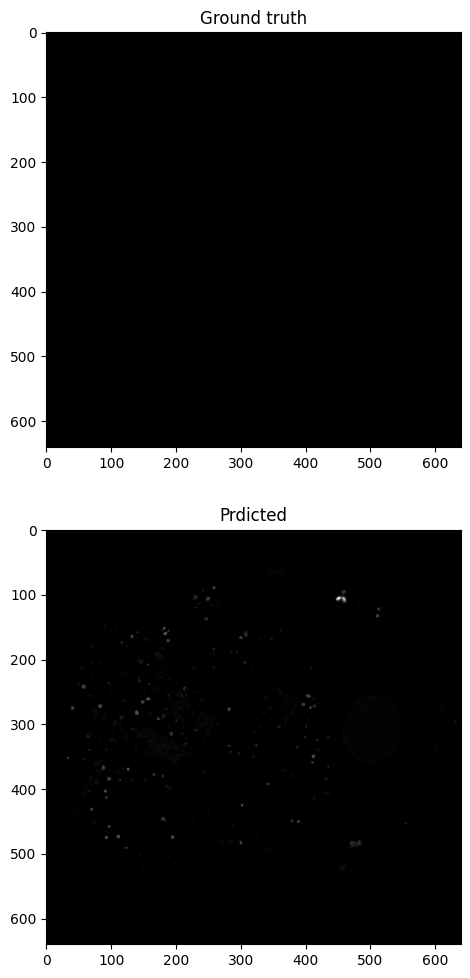

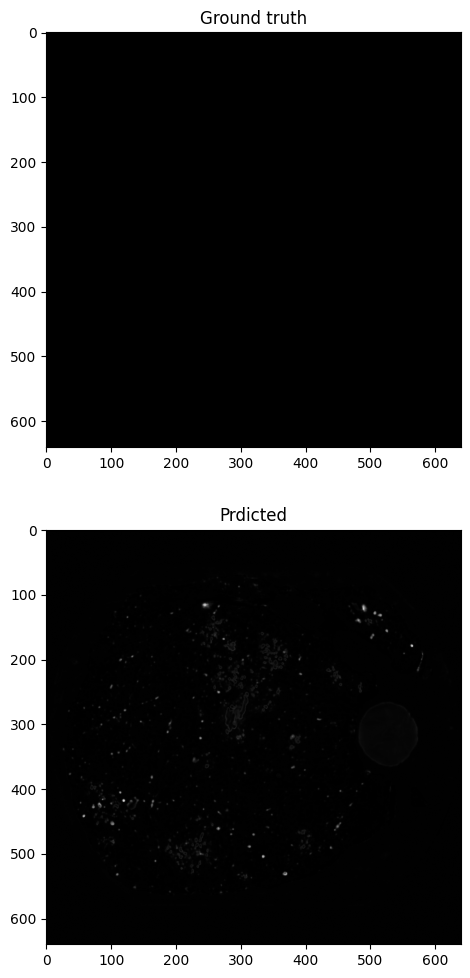

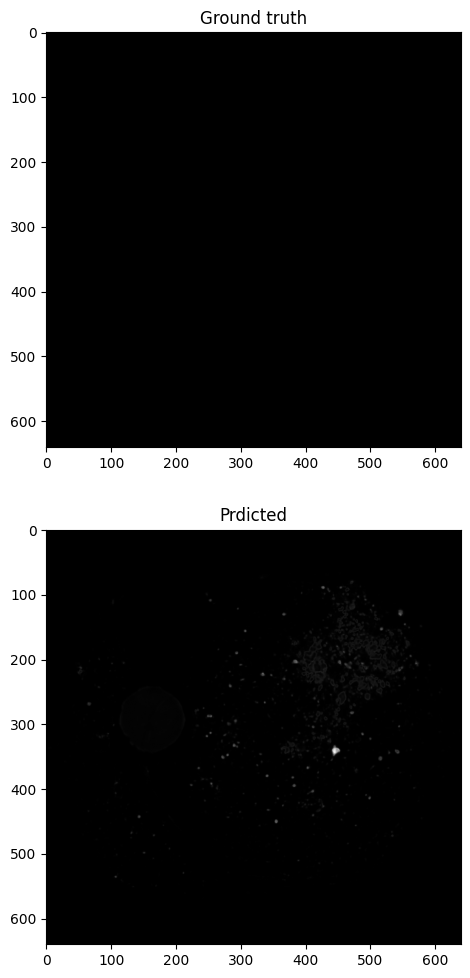

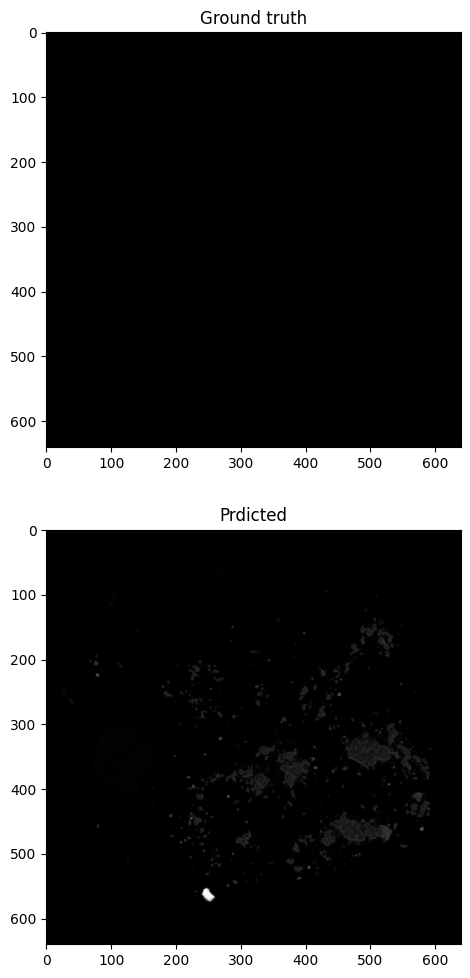

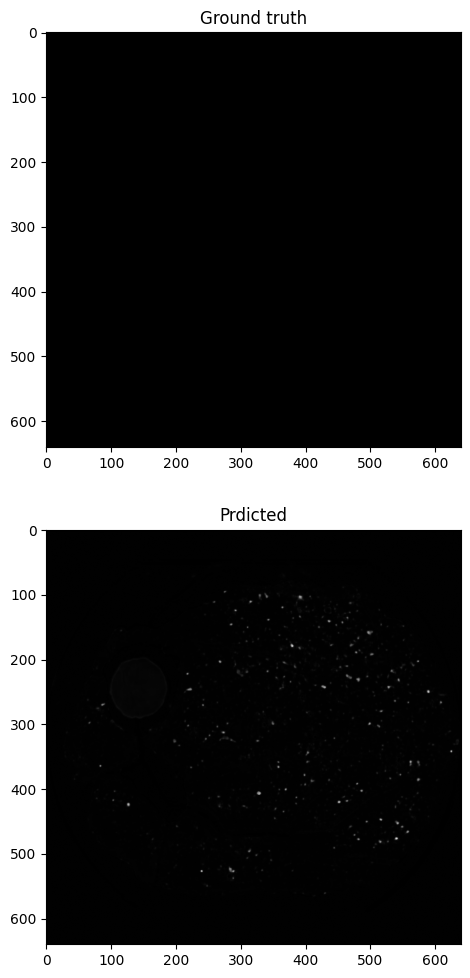

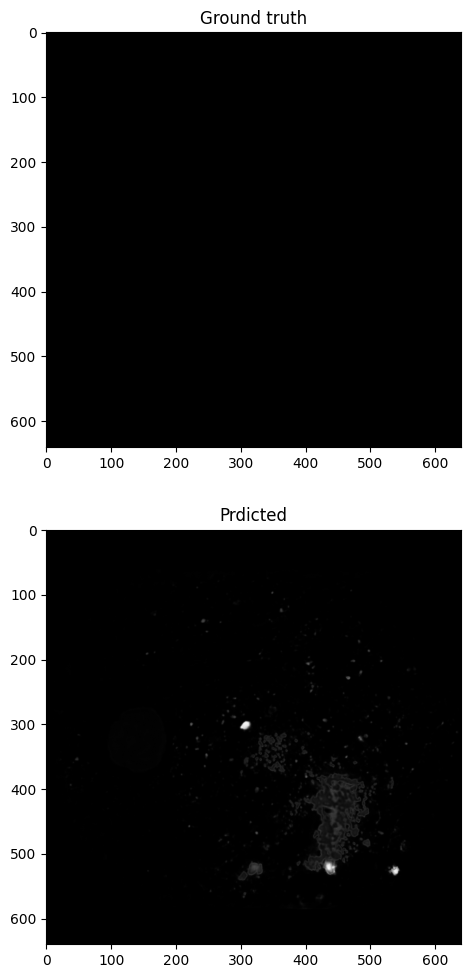

In [21]:
for test_batch_id, test_batch in enumerate(test_dataloader):                
    input_tensor = test_batch[0].to(device)
    target_tensor = test_batch[1].to(device)

    test_output = loaded_model(input_tensor)

    target_tensor = target_tensor.squeeze()
    test_output = test_output.squeeze()


    # fig = plt.figure()
    # for i in range(5):
    #     ax = fig.add_subplot(2,5,i+1)
    #     ax.imshow(target_tensor[i, ...].cpu(), cmap='gray')
    #     ax.set_title("Ground truth")

    # for i in range(5):
    #     ax = fig.add_subplot(2,5, i+5+1)
    #     ax.imshow(test_output[i, ...].cpu().detach(), cmap='gray')
    #     ax.set_title("Prdicted")

    lesion_index = 4

    fig = plt.figure()
    plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

    ax = fig.add_subplot(2,1,1)
    ax.imshow(target_tensor[lesion_index, ...].cpu(), cmap='gray')
    ax.set_title("Ground truth")

    ax = fig.add_subplot(2,1, 2)
    ax.imshow(test_output[lesion_index, ...].cpu().detach(), cmap='gray')
    ax.set_title("Prdicted")